<h3>Gráficos y datos de los modelos</h3>

Este cuaderno de jupyter está construido con el fin de mostrar distintas gráficas relacionadas con el rendimiento de los modelos y gracias a estos datos, sacar una conclusión sobre que modelo elegir para comparar posteriormente con un modelo de transformers

Primero vamos a cargar todas las librerías necesarias

In [1]:
import time
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    precision_recall_curve, 
    roc_curve, 
    auc
)
from traditional_split_data import data_split

En primer lugar se va a realizar una carga de los pipelines y de nuestro dataset spliteado en los distintos conjuntos

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = data_split()

models = {
'SVM'       : joblib.load('svm_pipeline.joblib'),
'LogReg'    : joblib.load('logreg_pipeline.joblib'),
'RF'        : joblib.load('rf_pipeline.joblib'),
'NB'        : joblib.load('nb_pipeline.joblib'),
'LogRegCal' : joblib.load('logregcal_pipeline.joblib'),
'HGB'       : joblib.load('hgb_pipeline.joblib'),
'XGBoost'   : joblib.load('xgboost_pipeline.joblib')
}

e:\Master\TFM\FakeNewsReactApp\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [10:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


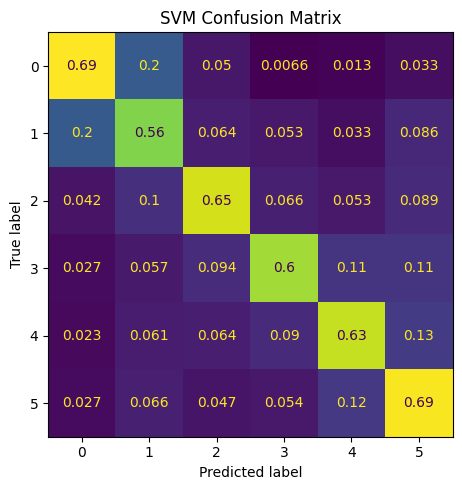

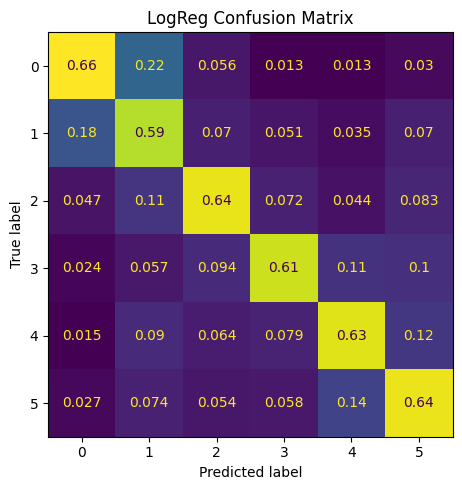

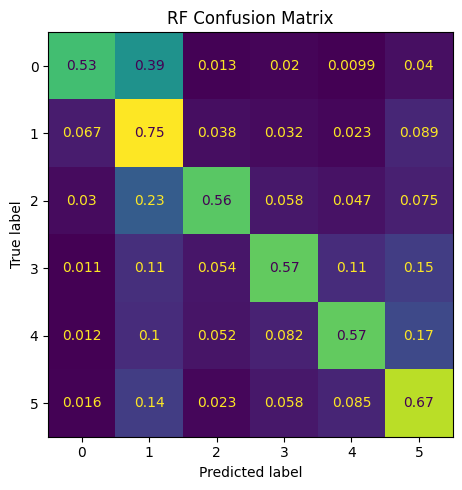

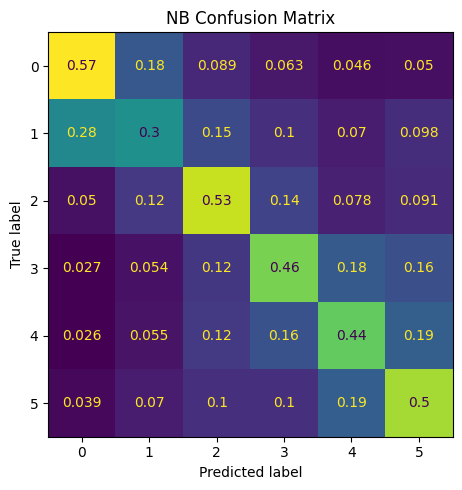

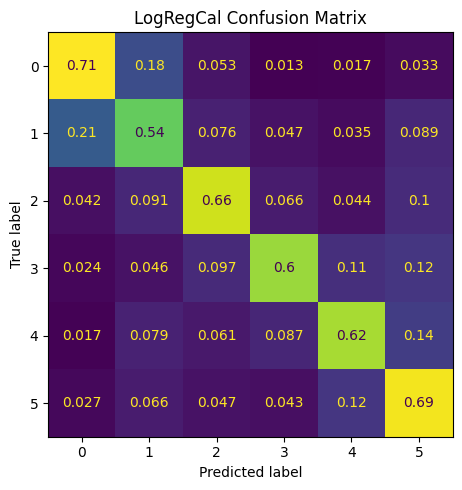

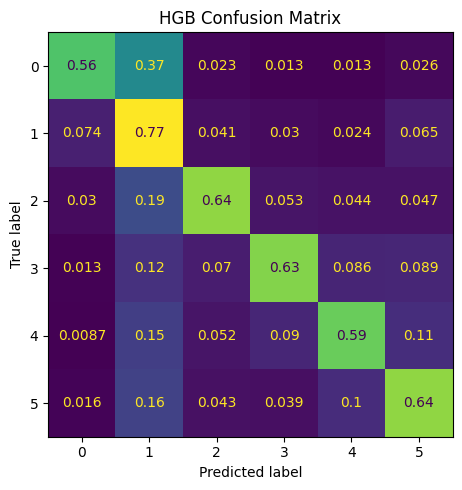

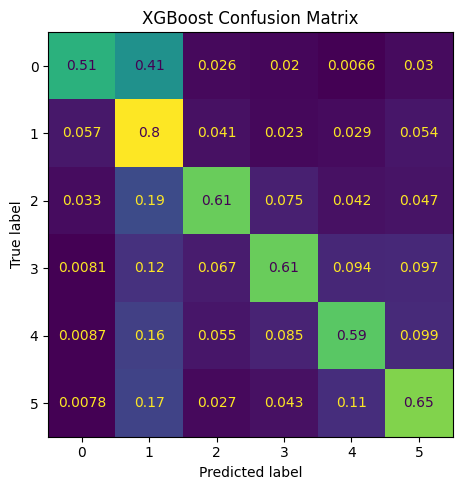

In [29]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        normalize='true',
        ax=ax,
        colorbar=False
    )
    ax.set_title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

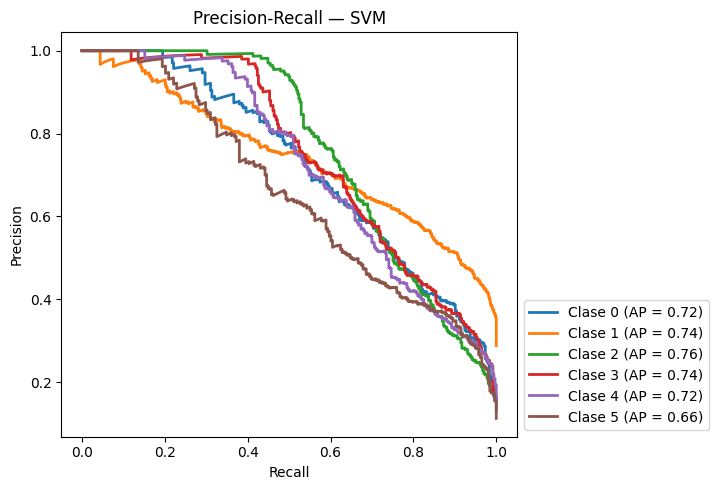

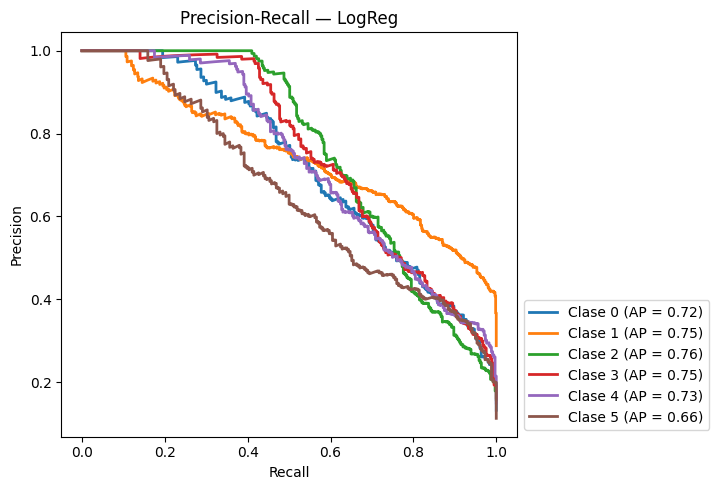

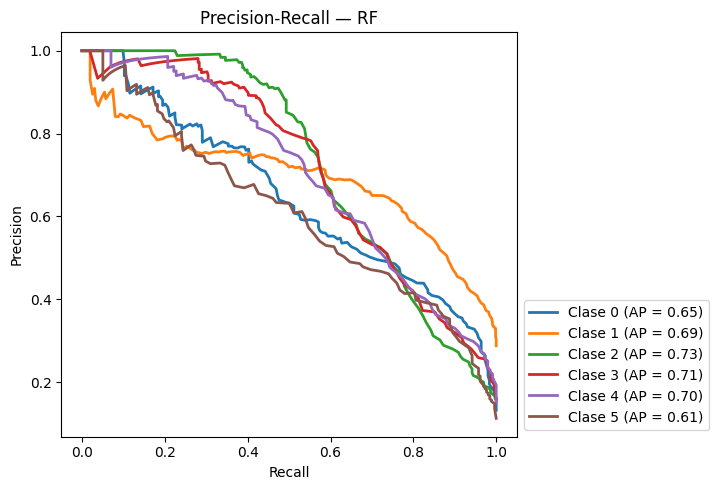

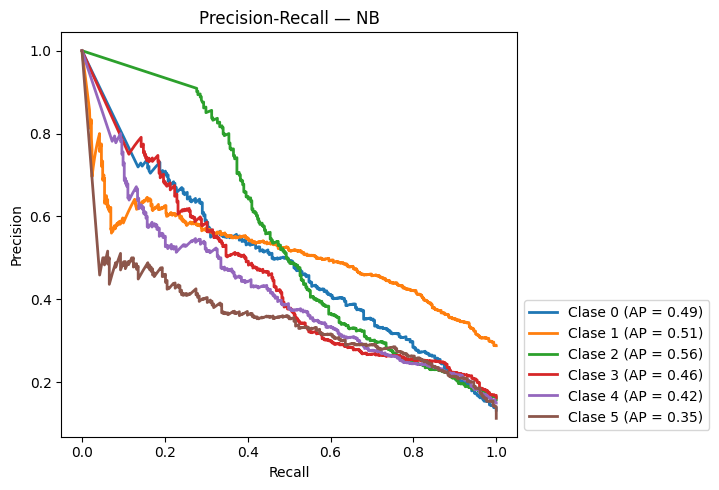

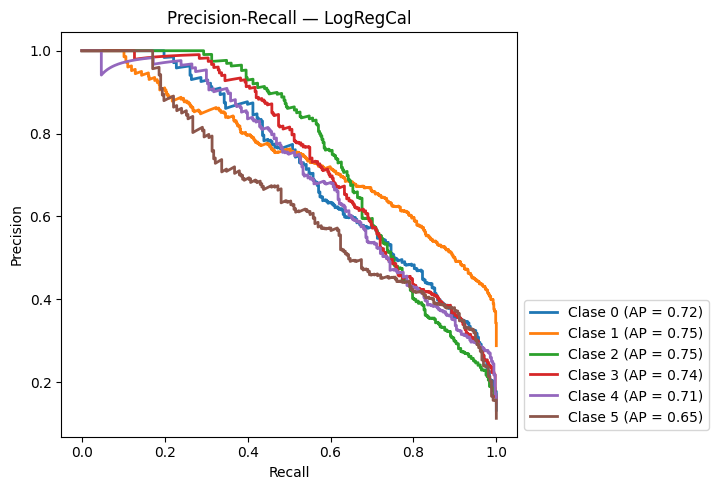

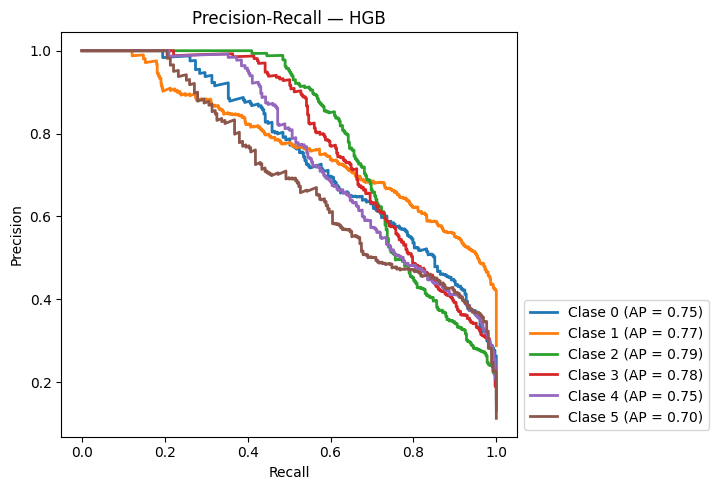

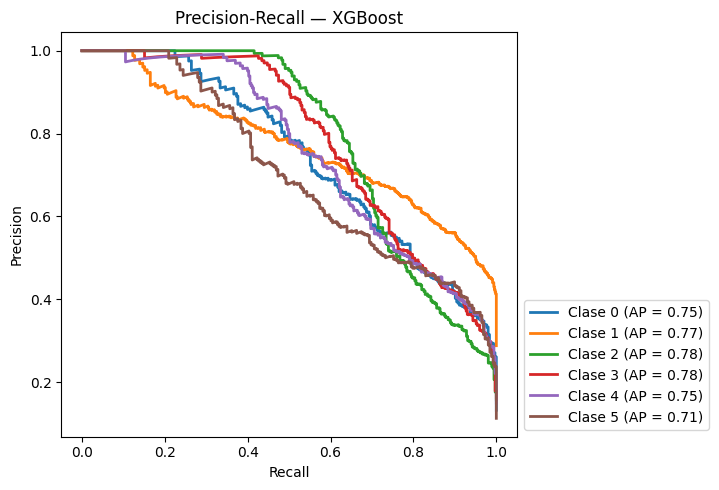

In [23]:
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
    else:
        probs = model.decision_function(X_test)
    n_classes = probs.shape[1]
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    
    for i in range(n_classes):
        y_true_bin = (y_test == i).astype(int)
        
        precision, recall, _ = precision_recall_curve(y_true_bin, probs[:, i])

        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, lw=2,
                 label=f'Clase {i} (AP = {pr_auc:.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall — {name}')
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.tight_layout()
    plt.show()

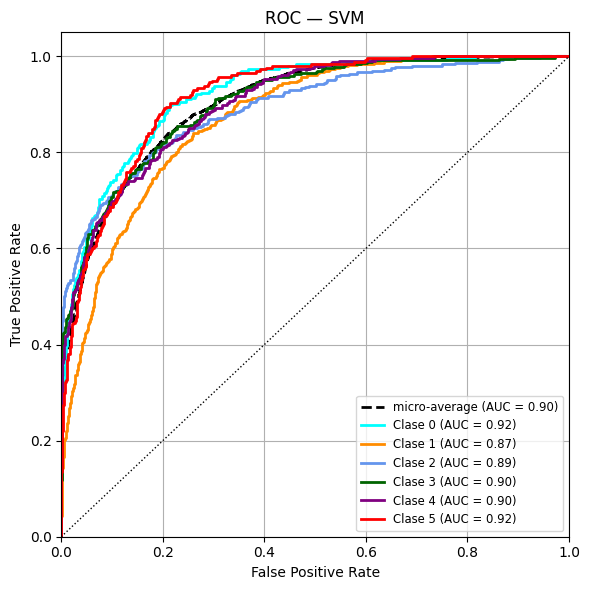

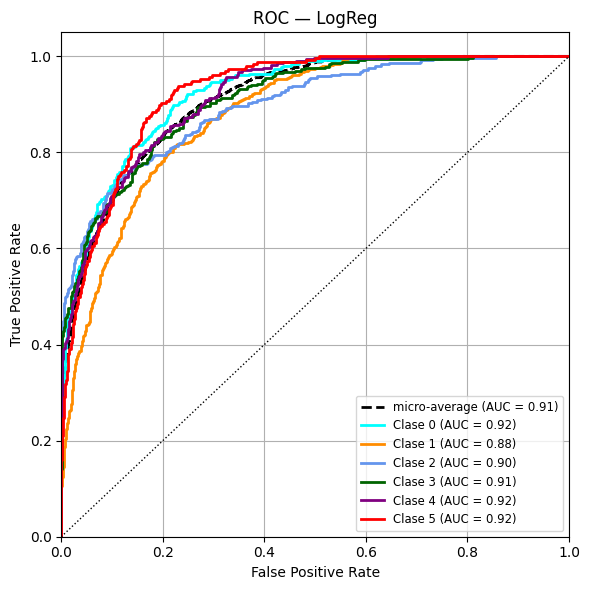

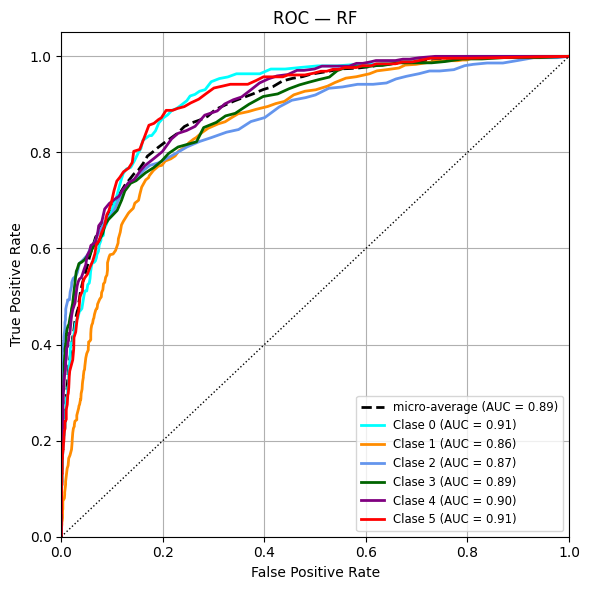

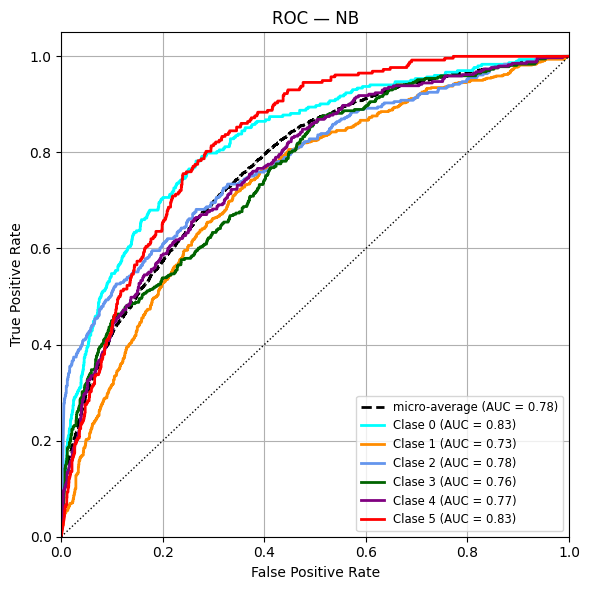

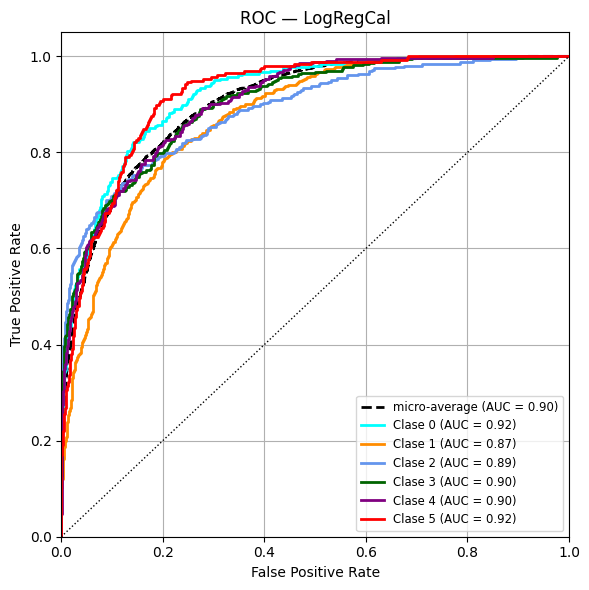

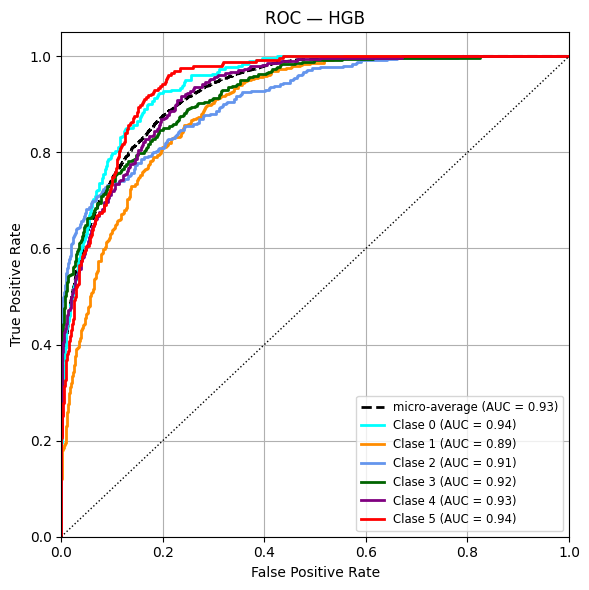

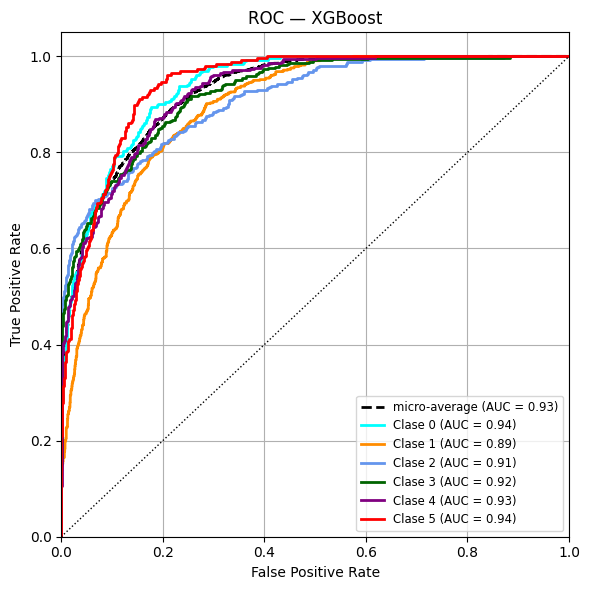

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4,5])
n_classes  = y_test_bin.shape[1]

#Para cada modelo curvas ROC / AUC
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _    = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i]          = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"]              = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(6,6))
    # micro-average
    plt.plot(
        fpr["micro"], tpr["micro"],
        label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
        color='black', linestyle='--', linewidth=2
    )

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i], tpr[i], color=color, lw=2,
            label=f'Clase {i} (AUC = {roc_auc[i]:.2f})'
        )

    plt.plot([0,1], [0,1], 'k:', lw=1)
    plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC — {name}')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
timings = {}
for name, model in models.items():
    t0 = time.time()
    _ = model.predict(X_test)
    pred_time = time.time() - t0
    timings[name] = (pred_time)

In [15]:
print("Modelo   Predict time (s)")
for name, p in timings.items():
    print(f"{name:10}   {p:8.2f}")

Modelo   Predict time (s)
SVM              1.85
LogReg           1.91
RF               2.27
NB               0.24
LogRegCal        1.85
HGB              2.50
XGBoost          1.87


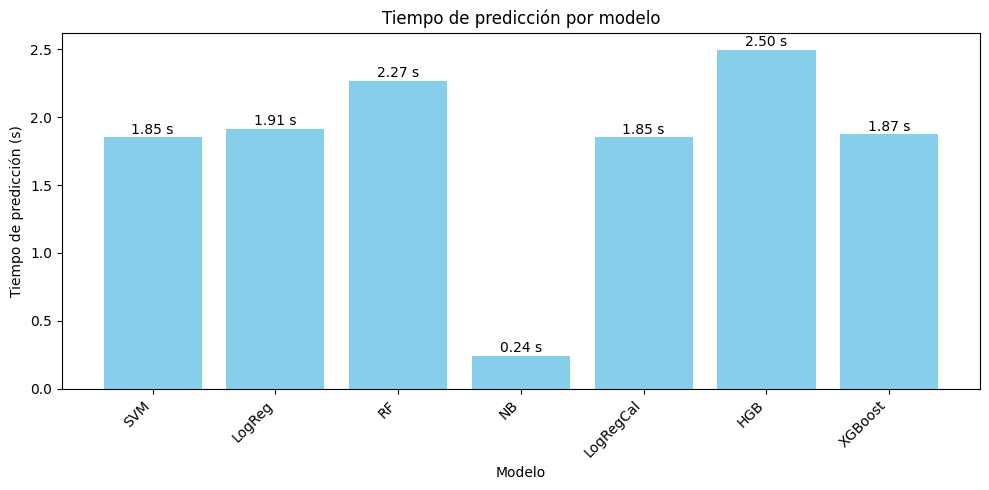

In [26]:
modelos = list(timings.keys())
tiempos = list(timings.values())


plt.figure(figsize=(10, 5))
bars = plt.bar(modelos, tiempos, color='skyblue')
plt.xlabel('Modelo')
plt.ylabel('Tiempo de predicción (s)')
plt.title('Tiempo de predicción por modelo')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  
        height + 0.005,                   
        f'{height:.2f} s',                  
        ha='center', va='bottom'          
    )

plt.tight_layout()
plt.show()


=== SVM ===
Log-loss: 1.0751
Brier score por clase: ['0.0684', '0.1557', '0.0732', '0.0776', '0.0747', '0.0639']
Brier score (media): 0.0856
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       303
           1       0.70      0.56      0.63       661
           2       0.65      0.65      0.65       361
           3       0.68      0.60      0.64       371
           4       0.65      0.63      0.64       343
           5       0.49      0.69      0.57       258

    accuracy                           0.62      2297
   macro avg       0.62      0.64      0.62      2297
weighted avg       0.64      0.62      0.63      2297



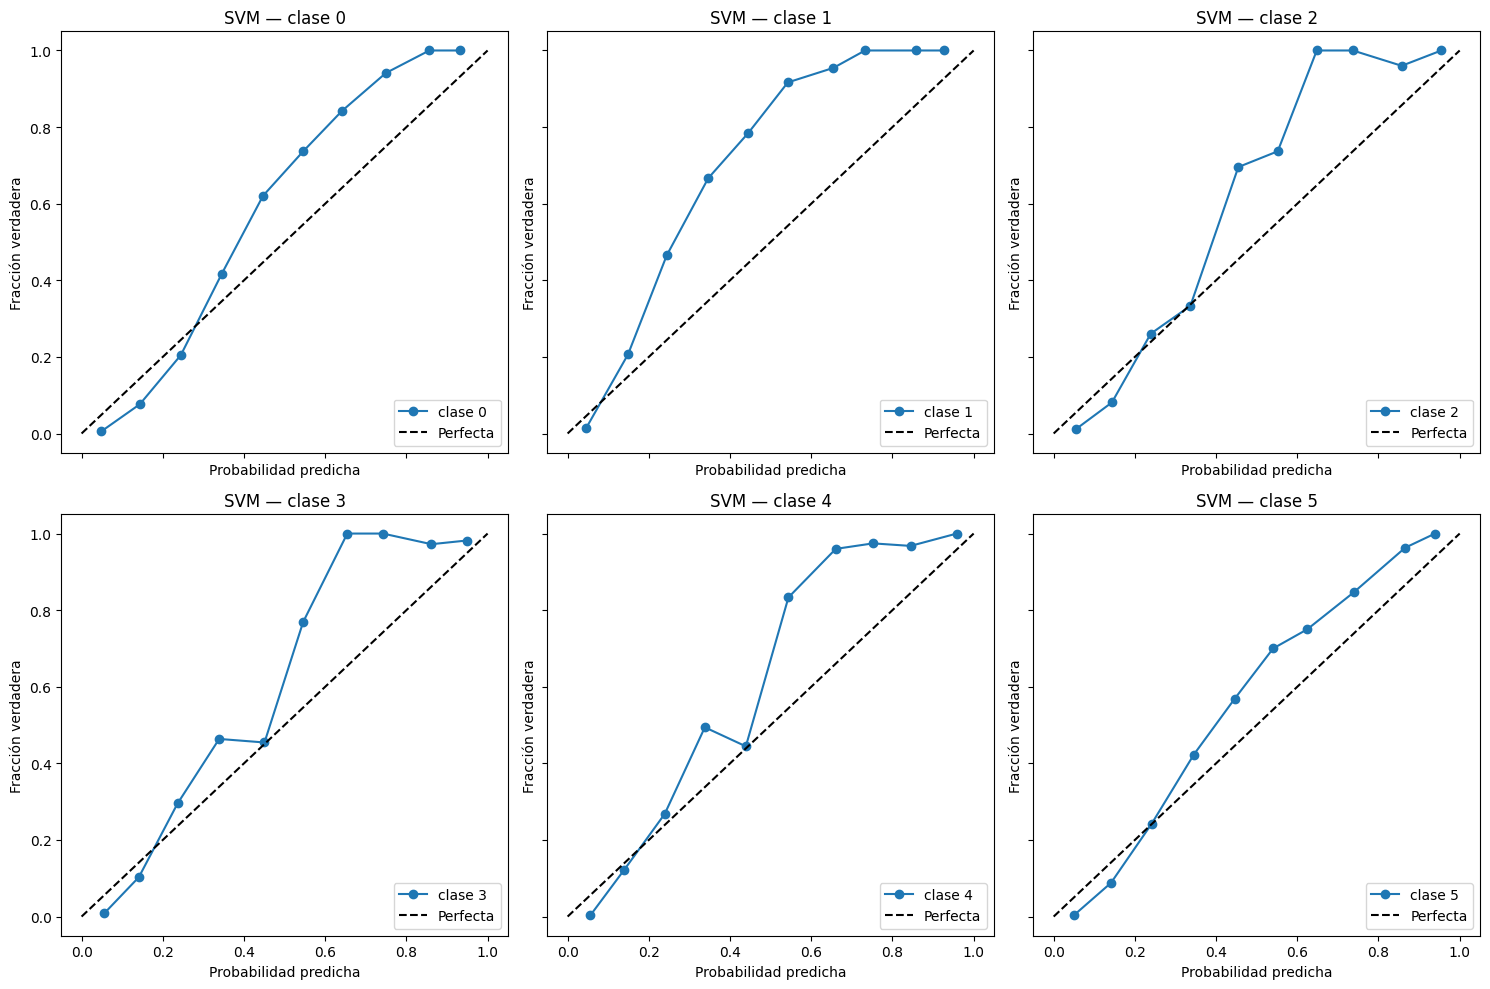


=== LogReg ===
Log-loss: 0.9645
Brier score por clase: ['0.0681', '0.1325', '0.0719', '0.0744', '0.0736', '0.0648']
Brier score (media): 0.0809
              precision    recall  f1-score   support

           0       0.56      0.66      0.61       303
           1       0.69      0.59      0.63       661
           2       0.63      0.64      0.64       361
           3       0.68      0.61      0.65       371
           4       0.64      0.63      0.64       343
           5       0.50      0.64      0.56       258

    accuracy                           0.62      2297
   macro avg       0.62      0.63      0.62      2297
weighted avg       0.63      0.62      0.63      2297



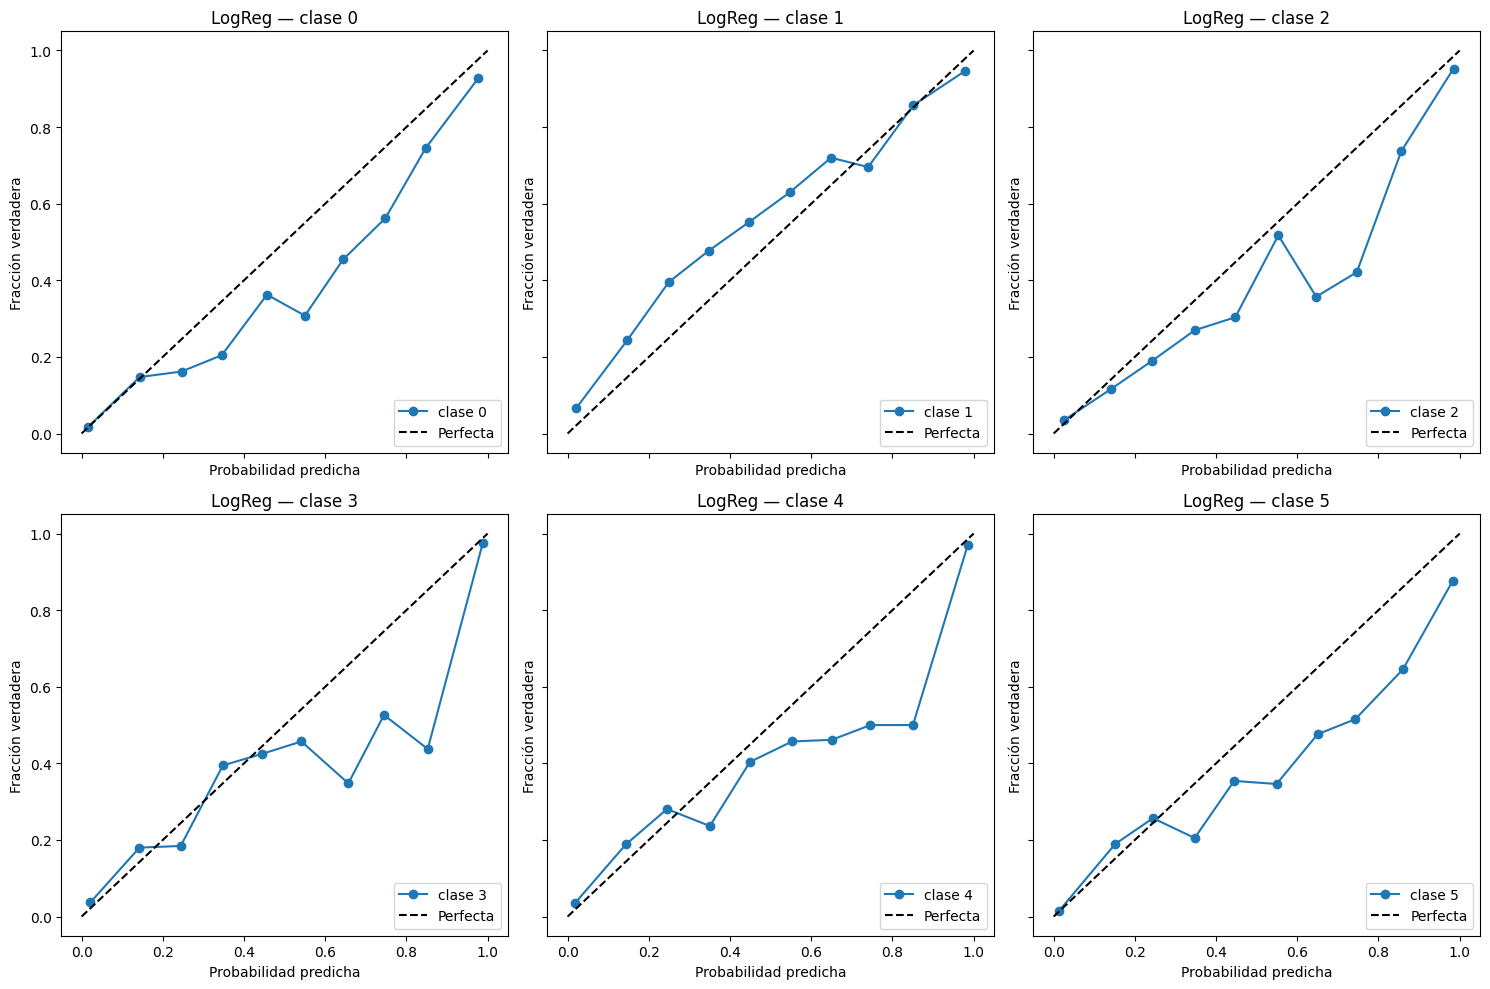


=== RF ===
Log-loss: 1.1216
Brier score por clase: ['0.0733', '0.1403', '0.0794', '0.0850', '0.0813', '0.0701']
Brier score (media): 0.0882
              precision    recall  f1-score   support

           0       0.70      0.53      0.60       303
           1       0.61      0.75      0.68       661
           2       0.74      0.56      0.64       361
           3       0.70      0.57      0.63       371
           4       0.67      0.57      0.62       343
           5       0.45      0.67      0.54       258

    accuracy                           0.63      2297
   macro avg       0.65      0.61      0.62      2297
weighted avg       0.65      0.63      0.63      2297



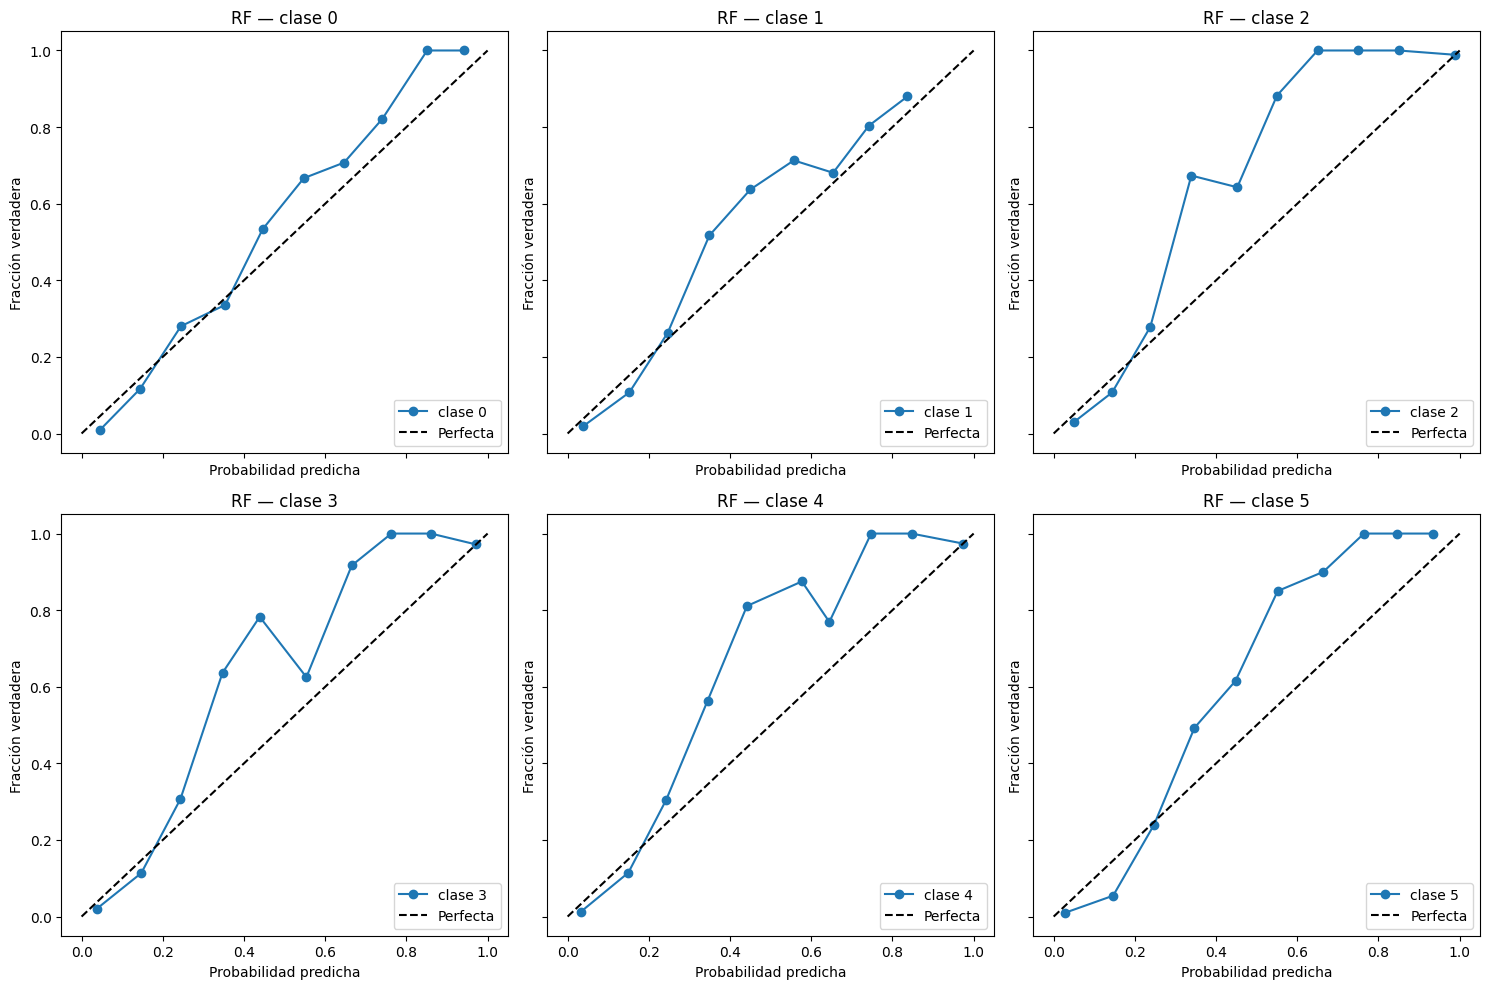


=== NB ===
Log-loss: 10.0201
Brier score por clase: ['0.1503', '0.2546', '0.1620', '0.1685', '0.1597', '0.1492']
Brier score (media): 0.1740
              precision    recall  f1-score   support

           0       0.43      0.57      0.49       303
           1       0.57      0.30      0.39       661
           2       0.45      0.53      0.49       361
           3       0.44      0.46      0.45       371
           4       0.43      0.44      0.43       343
           5       0.35      0.50      0.41       258

    accuracy                           0.44      2297
   macro avg       0.44      0.47      0.44      2297
weighted avg       0.46      0.44      0.44      2297



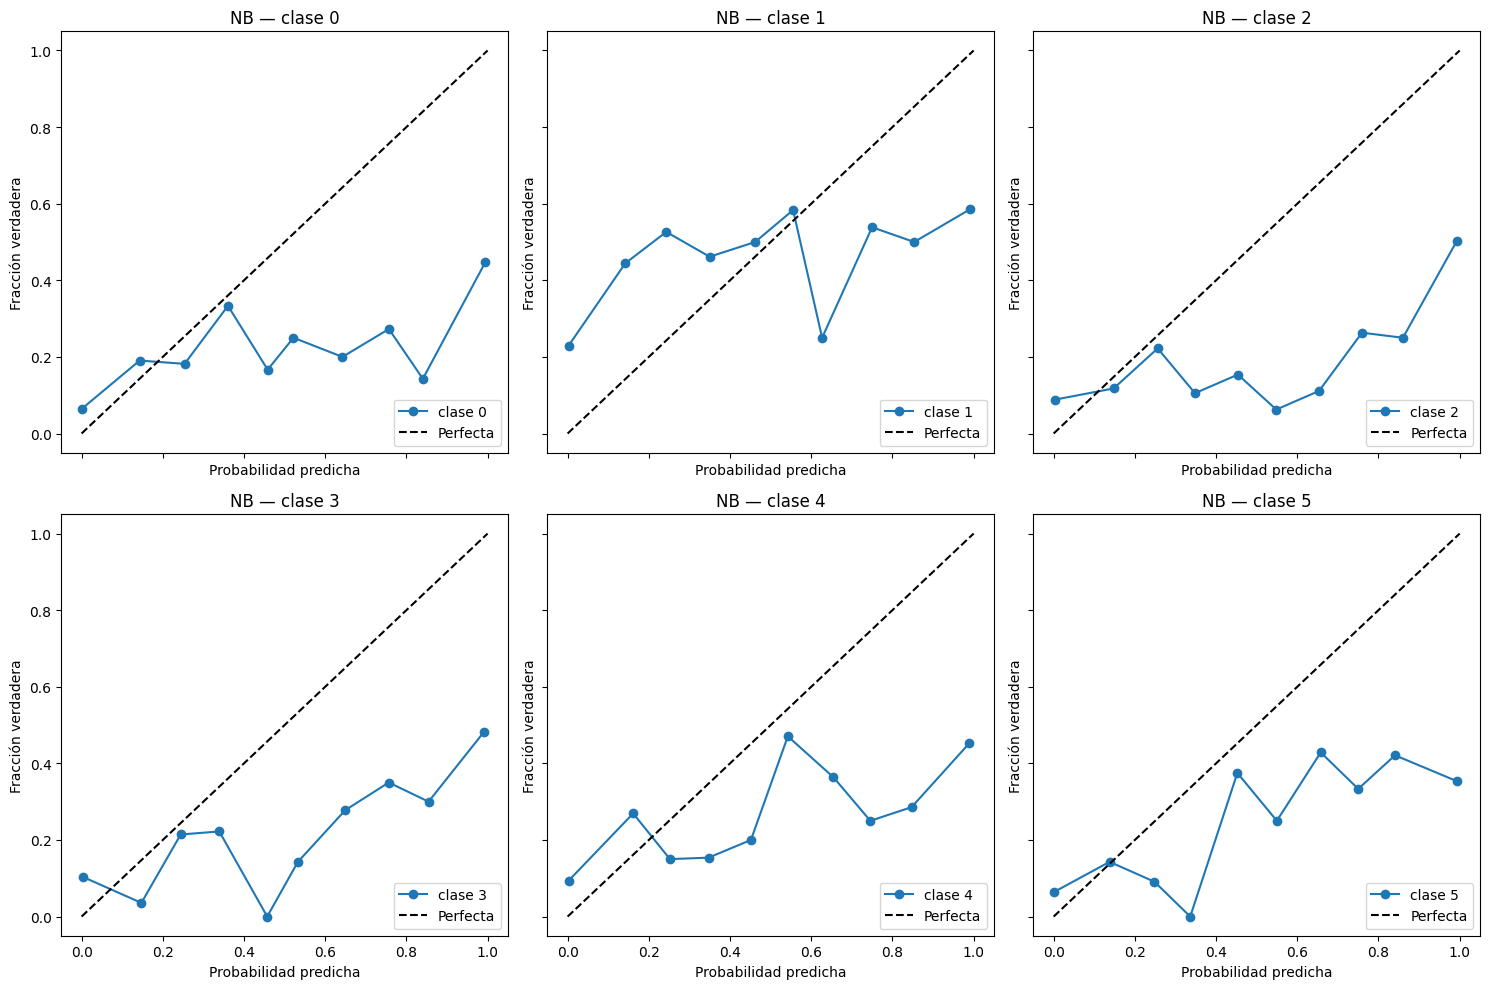


=== LogRegCal ===
Log-loss: 0.9851
Brier score por clase: ['0.0691', '0.1359', '0.0743', '0.0769', '0.0747', '0.0647']
Brier score (media): 0.0826
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       303
           1       0.71      0.54      0.61       661
           2       0.64      0.66      0.65       361
           3       0.69      0.60      0.64       371
           4       0.65      0.62      0.63       343
           5       0.47      0.69      0.56       258

    accuracy                           0.62      2297
   macro avg       0.62      0.64      0.62      2297
weighted avg       0.64      0.62      0.62      2297



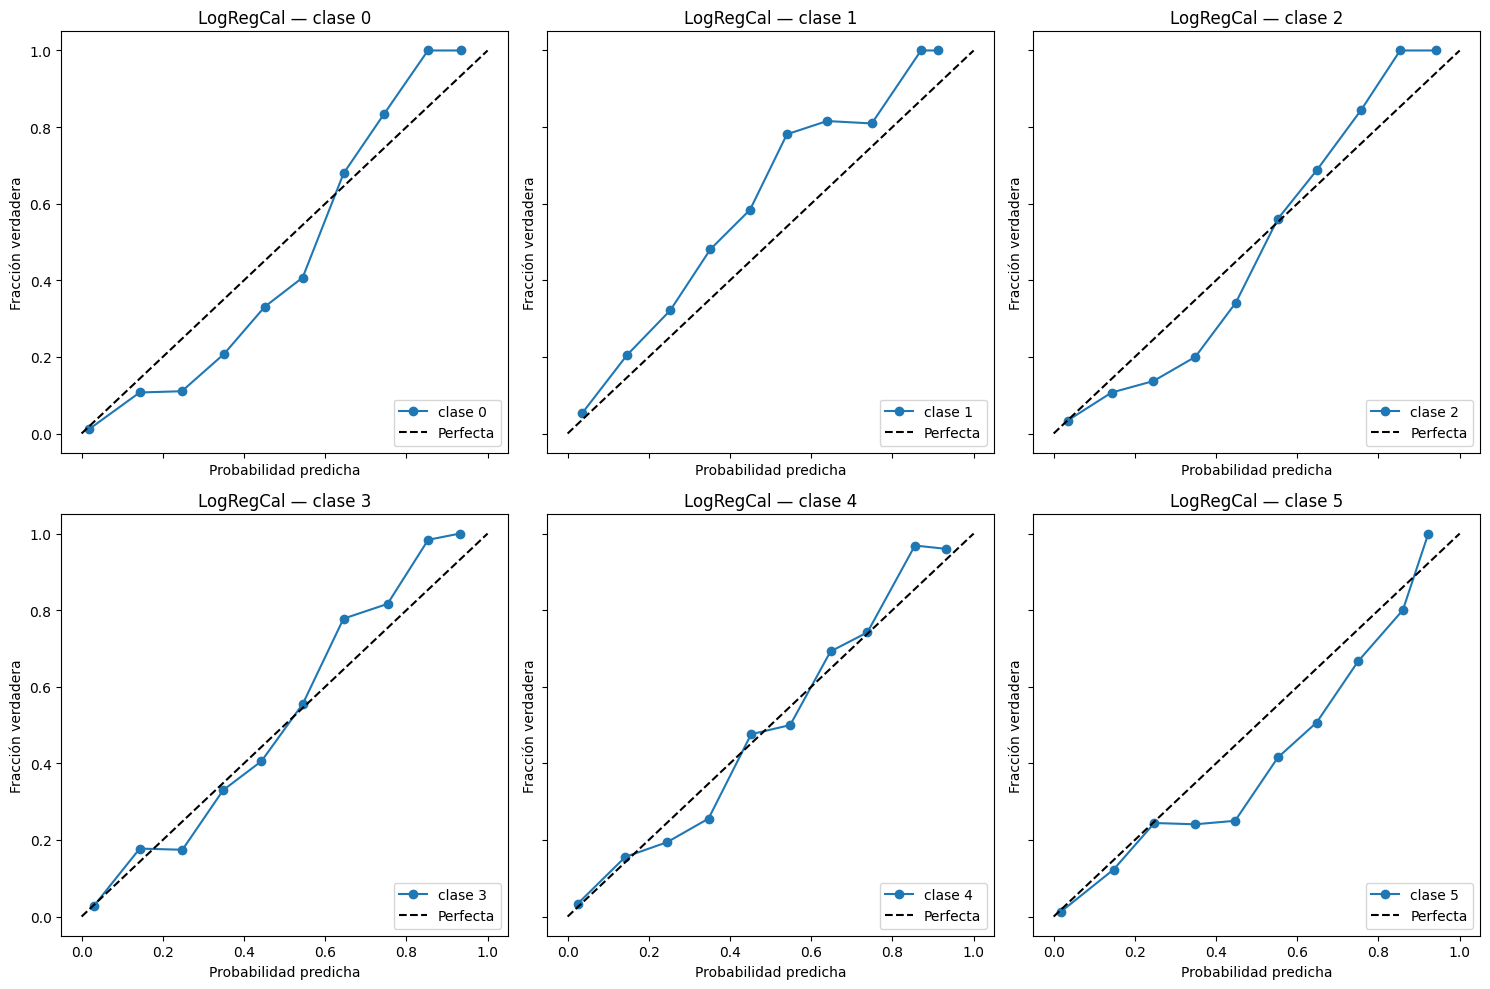


=== HGB ===
Log-loss: 0.8418
Brier score por clase: ['0.0599', '0.1184', '0.0637', '0.0672', '0.0675', '0.0569']
Brier score (media): 0.0723
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       303
           1       0.62      0.77      0.68       661
           2       0.72      0.64      0.68       361
           3       0.73      0.63      0.68       371
           4       0.68      0.59      0.63       343
           5       0.54      0.64      0.59       258

    accuracy                           0.66      2297
   macro avg       0.67      0.64      0.65      2297
weighted avg       0.67      0.66      0.66      2297



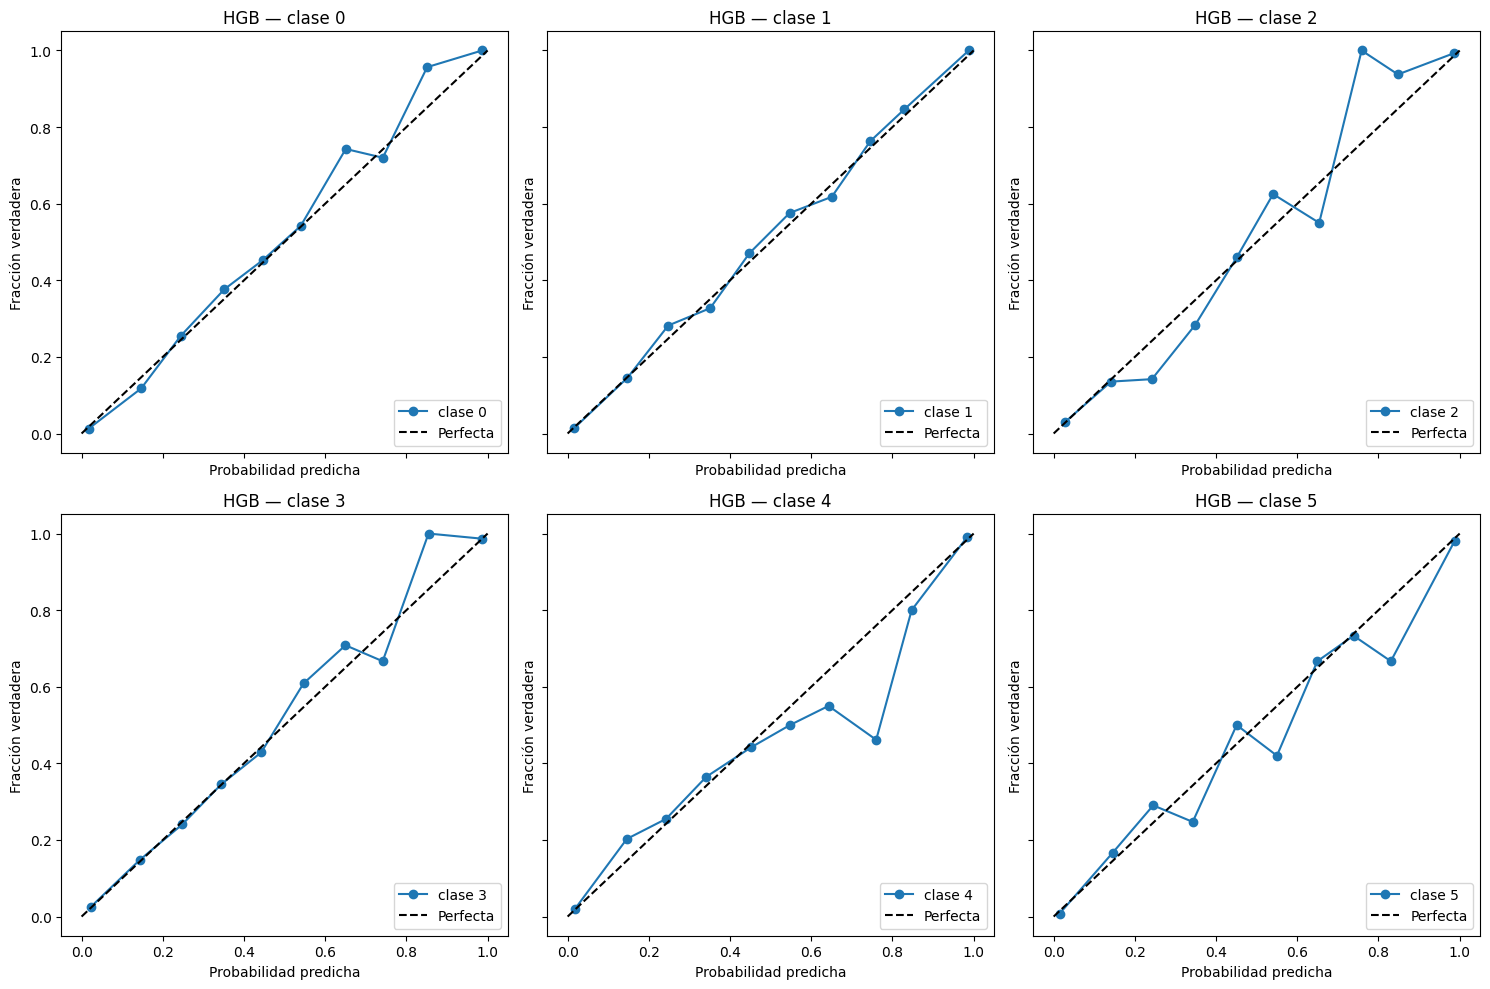


=== XGBoost ===
Log-loss: 0.8399
Brier score por clase: ['0.0610', '0.1188', '0.0644', '0.0671', '0.0678', '0.0557']
Brier score (media): 0.0725
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       303
           1       0.61      0.80      0.69       661
           2       0.72      0.61      0.66       361
           3       0.72      0.61      0.66       371
           4       0.67      0.59      0.63       343
           5       0.56      0.65      0.60       258

    accuracy                           0.65      2297
   macro avg       0.67      0.63      0.64      2297
weighted avg       0.67      0.65      0.65      2297



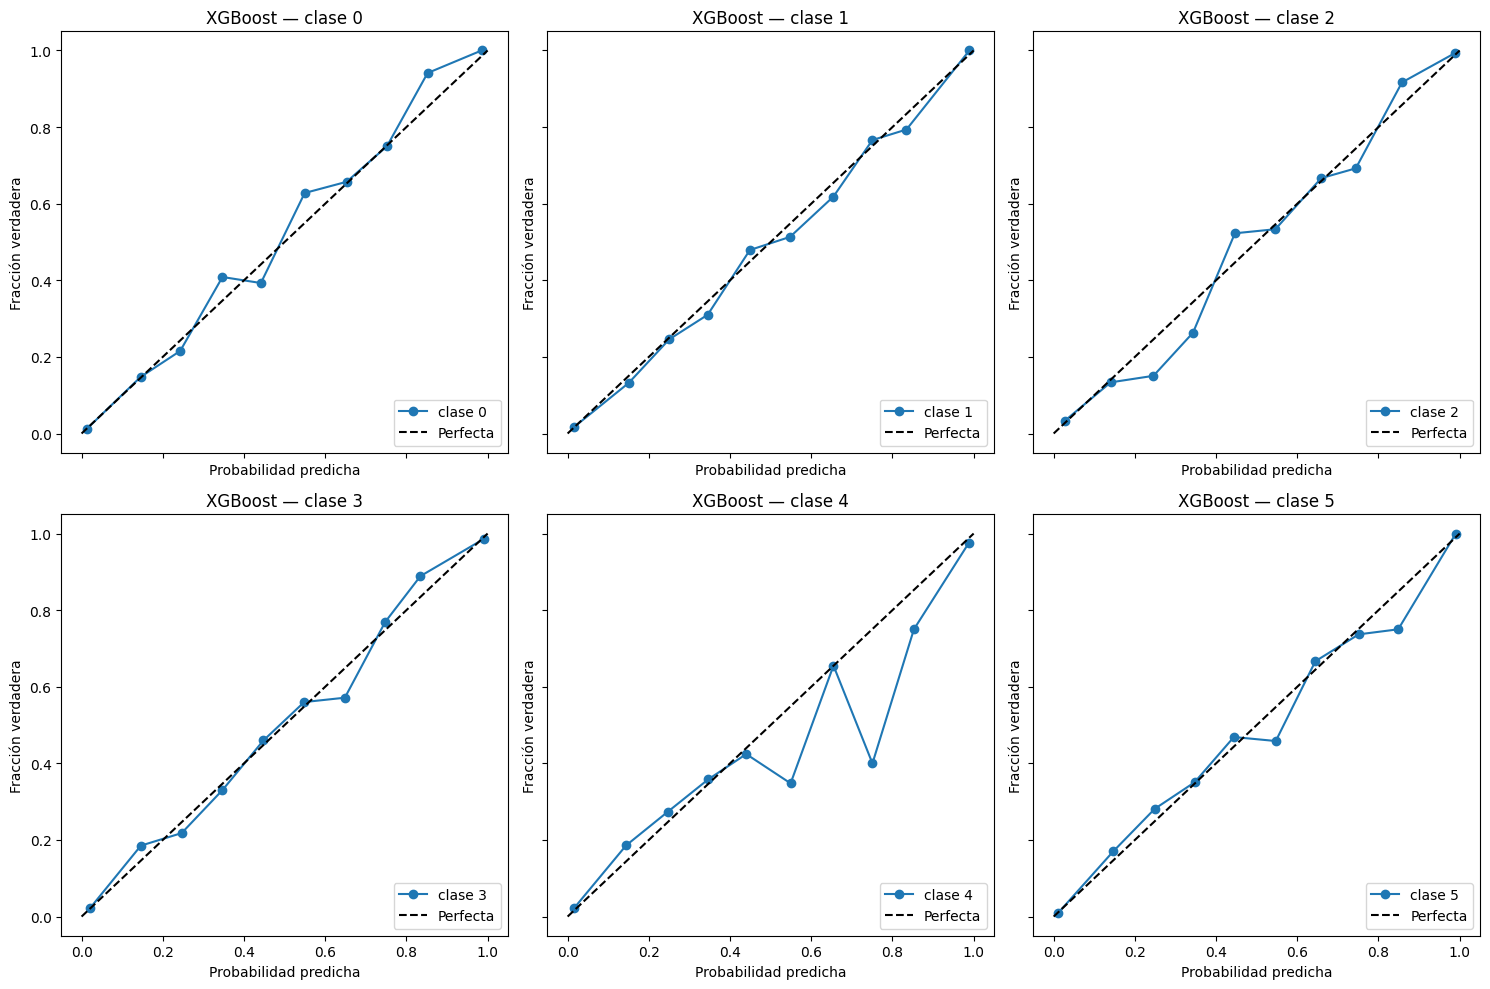

In [38]:
from sklearn.metrics import (
    log_loss,
    brier_score_loss,
    classification_report
)
from sklearn.calibration import calibration_curve

def softmax(z):
    expz = np.exp(z - np.max(z, axis=1, keepdims=True))
    return expz / expz.sum(axis=1, keepdims=True)

y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4,5])
n_classes = y_test_bin.shape[1]

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = model.decision_function(X_test)
        y_proba = softmax(y_proba)

    ll = log_loss(y_test, y_proba)
    
    # Brier para cada clase y luego media
    bs_per_class = [
        brier_score_loss(y_test_bin[:, i], y_proba[:, i])
        for i in range(n_classes)
    ]
    bs_mean = np.mean(bs_per_class)
    
    print(f"\n=== {name} ===")
    print(f"Log-loss: {ll:.4f}")
    print(f"Brier score por clase: {[f'{b:.4f}' for b in bs_per_class]}")
    print(f"Brier score (media): {bs_mean:.4f}")
    print(classification_report(y_test, model.predict(X_test), zero_division=0))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        prob_true, prob_pred = calibration_curve(
            y_test_bin[:, i],
            y_proba[:, i],
            n_bins=10
        )
        ax.plot(prob_pred, prob_true, marker='o', label=f"clase {i}")
        ax.plot([0, 1], [0, 1], 'k--', label='Perfecta')
        ax.set_title(f"{name} — clase {i}")
        ax.set_xlabel('Probabilidad predicha')
        ax.set_ylabel('Fracción verdadera')
        ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [3]:
import pandas as pd

# Función para humanizar dinámicamente nombres de features
def humanize_feature(name):
    # Mapas de prefijos a plantillas
    prefix_map = {
        'nums__': lambda m: (
            f"proporción de afirmaciones {m[:-5].replace('_', ' ')}"
            if m.endswith('_prop') else
            (f"longitud de {m[:-10].replace('_', ' ')} en caracteres"
             if m == m.endswith('_len_chars') else
             f"longitud de {m[:-10].replace('_', ' ')} en palabras"
             if m == m.endswith('_len_words') else
             "total de palabras")
        ),
        'justf__tfidf_word__': lambda m: f'presencia de la palabra "{m}" en la justificación',
        'justf__tfidf_char__': lambda m: f'presencia del token de caracteres "{m}" en la justificación',
        'spkdesc__tfidf_word__': lambda m: f'presencia de la palabra "{m}" en la descripcion de orador',
        'spkdesc__tfidf_char__': lambda m: f'presencia del token de caracteres "{m}" en la descripcion de orador',
        'stmt__tfidf_word__': lambda m: f'presencia del token de caracteres "{m}" en el enunciado',
        'stmt__tfidf_char__': lambda m: f'presencia del token de palabras "{m}" en el enunciado',
        'subj__tfidf_char__': lambda m: f'presencia del token de caracteres "{m}" en el sujeto',
        'subj__tfidf_word__': lambda m: f'presencia del token de palabras "{m}" en el sujeto',
        'cats__': lambda m: f"categoría '{m.replace('_', ' ')}'"
    }
    for prefix, template in prefix_map.items():
        if name.startswith(prefix):
            metric = name[len(prefix):]
            return template(metric)
    # Fallback genérico
    return name.replace('__', ' ').replace('_', ' ')

e:\Master\TFM\FakeNewsReactApp\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\Master\TFM\FakeNewsReactApp\.venv\lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


→ Clase predicha = 1 (p≈-0.08)

 Top 20 features que empujan hacia la clase 1:
                      feature  shap_value
             nums__false_prop    0.458588
       nums__mostly_true_prop    0.076137
justf__tfidf_word__post claim    0.072767
              nums__true_prop    0.064549
      stmt__tfidf_char__rris     0.063854
        stmt__tfidf_char__la     0.050265
         nums__half_true_prop    0.049514
 cats__ctx_social_media_False    0.048652
      stmt__tfidf_char__arris    0.038183
    spkdesc__tfidf_char__oste    0.038144
    nums__statement_len_chars    0.031005
                   nums__year    0.029895
     spkdesc__tfidf_char__ook    0.025774
nums__justification_len_words    0.023753
     stmt__tfidf_word__harris    0.021751
      stmt__tfidf_char__deral    0.020441
        subj__tfidf_char___ch    0.018689
      nums__mostly_false_prop    0.017002
    stmt__tfidf_word__federal    0.016240
      stmt__tfidf_char__ fede    0.015039

 Top 20 features que frenan la clase 1

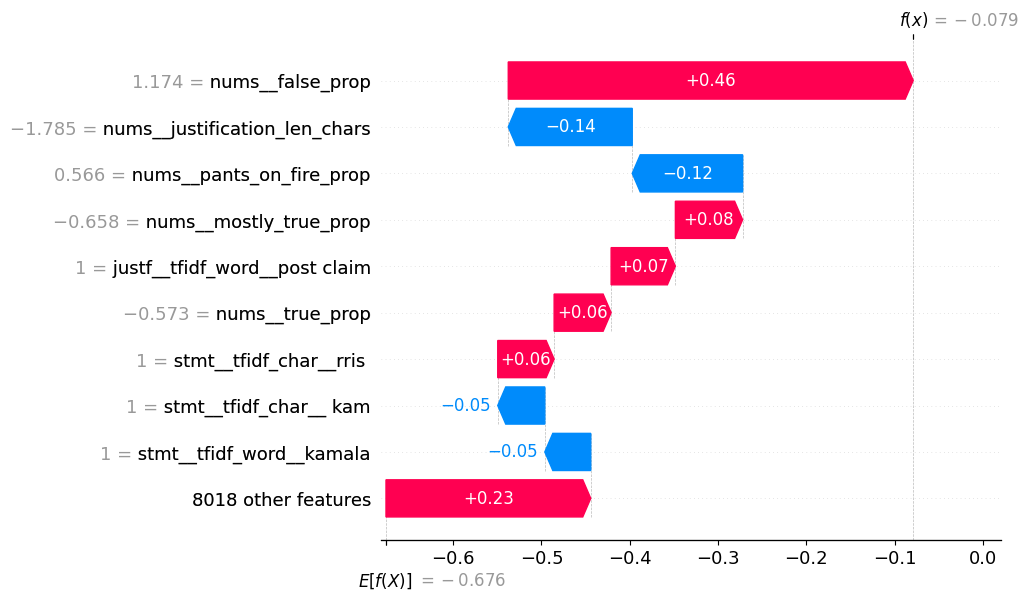

e:\Master\TFM\FakeNewsReactApp\.venv\lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


→ Clase predicha = 1 (p≈0.56)

 Top 20 features que empujan hacia la clase 1:
                            feature  shap_value
                   nums__false_prop    1.328616
             nums__mostly_true_prop    0.263367
               nums__half_true_prop    0.214229
                    nums__true_prop    0.155367
            stmt__tfidf_char__rris     0.142599
                         nums__year    0.137742
              stmt__tfidf_char__la     0.136330
          nums__statement_len_chars    0.120974
            stmt__tfidf_char__ harr    0.094495
        cats__ctx_social_media_True    0.093969
nums__speaker_description_len_chars    0.070913
            stmt__tfidf_char__arris    0.070284
         spkdesc__tfidf_char__ face    0.061653
          spkdesc__tfidf_char__face    0.061618
             stmt__tfidf_char__ala     0.058612
            nums__mostly_false_prop    0.056315
           stmt__tfidf_word__harris    0.054321
           spkdesc__tfidf_char__ook    0.050628
          

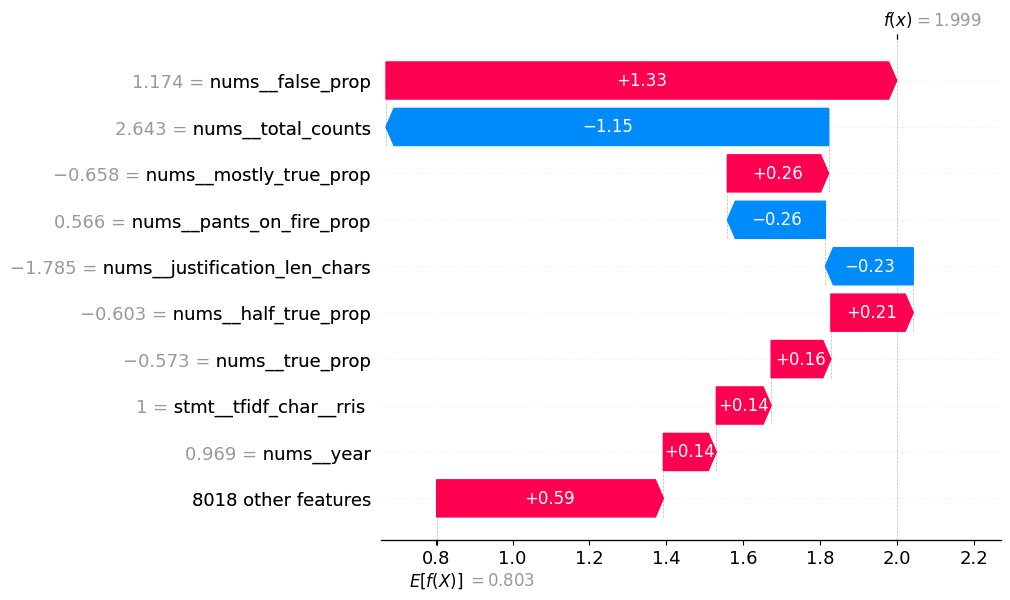

→ Clase predicha = 1 (p≈0.65)

 Top 20 features que empujan hacia la clase 1:
                 feature  shap_value
        nums__false_prop    0.026039
  nums__mostly_true_prop    0.006595
   subj__tfidf_char___fa    0.005664
         nums__true_prop    0.005621
  subj__tfidf_char__act_    0.005492
  subj__tfidf_char__ecks    0.005480
  subj__tfidf_char__ fac    0.004749
  subj__tfidf_char__ok_f    0.004574
 justf__tfidf_char__ pro    0.004540
   subj__tfidf_char__hec    0.004497
   subj__tfidf_char__cks    0.004460
 subj__tfidf_char__book_    0.004290
 subj__tfidf_char___fact    0.004237
   subj__tfidf_char___ch    0.004160
  subj__tfidf_char___fac    0.003881
 subj__tfidf_char__ecks     0.003824
              nums__year    0.003802
 subj__tfidf_char__ebook    0.003759
justf__tfidf_char__acebo    0.003735
   subj__tfidf_char__ceb    0.003641

 Top 20 features que frenan la clase 1:
                        feature  shap_value
         stmt__tfidf_char__said   -0.001860
          stmt__

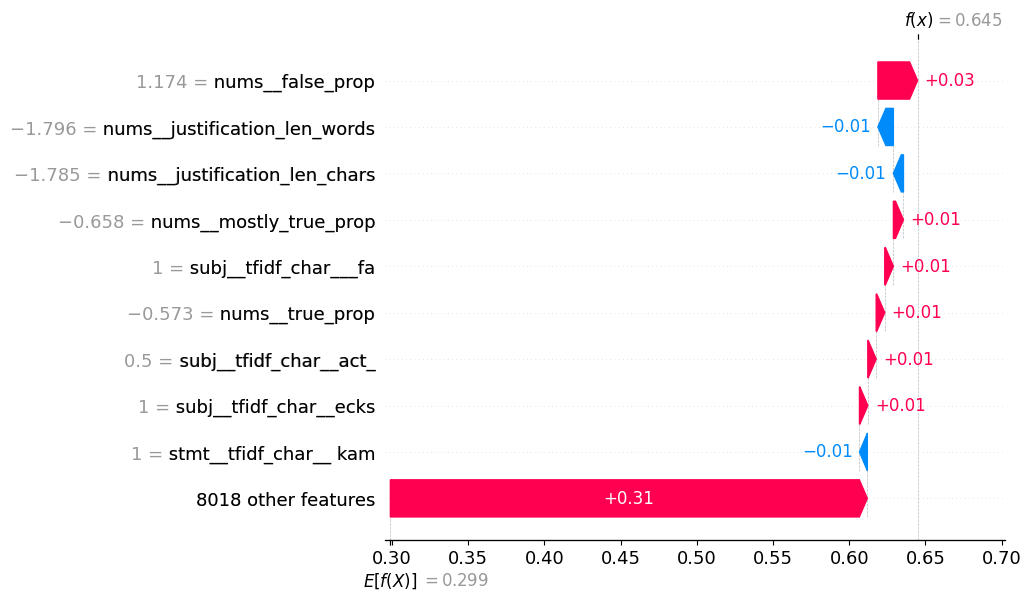

→ Clase predicha = 1 (p≈0.74)

 Top 20 features que empujan hacia la clase 1:
                    feature  shap_value
           nums__false_prop    1.235850
   justf__tfidf_char__ clai    0.169553
   justf__tfidf_char__accur    0.088496
                 nums__year    0.051333
 justf__tfidf_word__correct    0.046649
      subj__tfidf_char___ch    0.043605
cats__ctx_verbal_event_True    0.041931
    justf__tfidf_char__ imp    0.036668
    justf__tfidf_char__ntex    0.027081
 justf__tfidf_word__context    0.024517
     justf__tfidf_char__ar     0.022625
     justf__tfidf_char__af     0.019670
 justf__tfidf_word__element    0.019652
    justf__tfidf_char__ cla    0.018800
     stmt__tfidf_char__ say    0.017307
    justf__tfidf_char__ rig    0.016872
    justf__tfidf_char__elem    0.016872
      subj__tfidf_char__ fa    0.016748
     justf__tfidf_char__res    0.015551
    justf__tfidf_char__ pro    0.015285

 Top 20 features que frenan la clase 1:
                              feature  sh

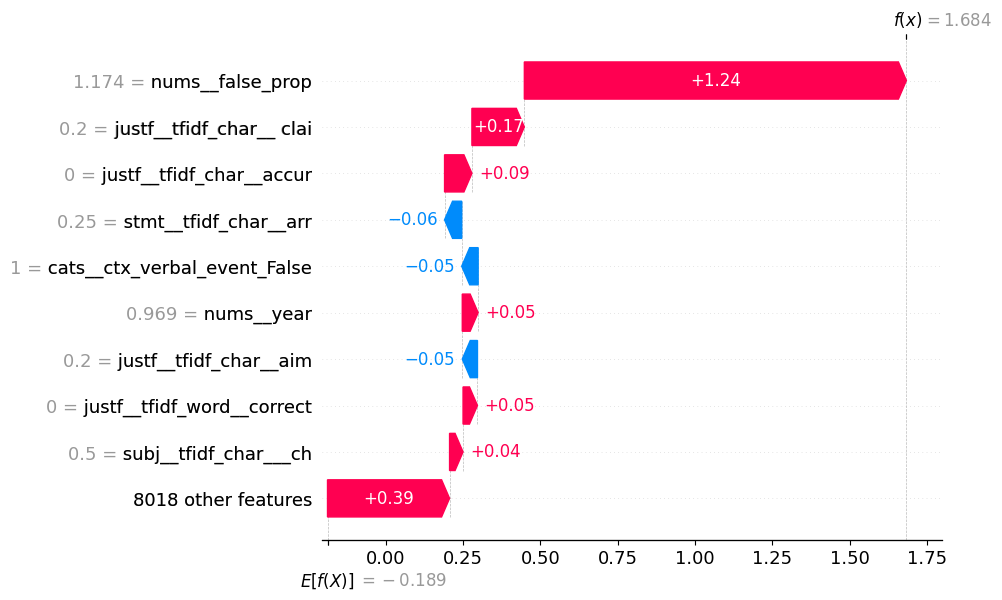

→ Clase predicha = 2 (p≈0.86)

 Top 20 features que empujan hacia la clase 2:
                     feature  shap_value
     nums__mostly_false_prop    0.613015
       stmt__tfidf_char__tax    0.138535
     justf__tfidf_char__ pro    0.095723
       stmt__tfidf_char__ati    0.079182
      justf__tfidf_char__nt     0.061295
      justf__tfidf_char__ de    0.056460
   nums__statement_len_chars    0.049039
      justf__tfidf_char__era    0.047115
     justf__tfidf_char__ sta    0.043269
    spkdesc__tfidf_char__ver    0.042071
    spkdesc__tfidf_char__ost    0.038007
      justf__tfidf_char__ess    0.037479
      justf__tfidf_char__ort    0.030018
    spkdesc__tfidf_char__ de    0.029283
    justf__tfidf_char__ally     0.028176
            nums__false_prop    0.026733
    subj__tfidf_word__states    0.024432
    spkdesc__tfidf_char__or     0.022989
justf__tfidf_word__statement    0.022197
    justf__tfidf_char__ cont    0.021704

 Top 20 features que frenan la clase 2:
                    

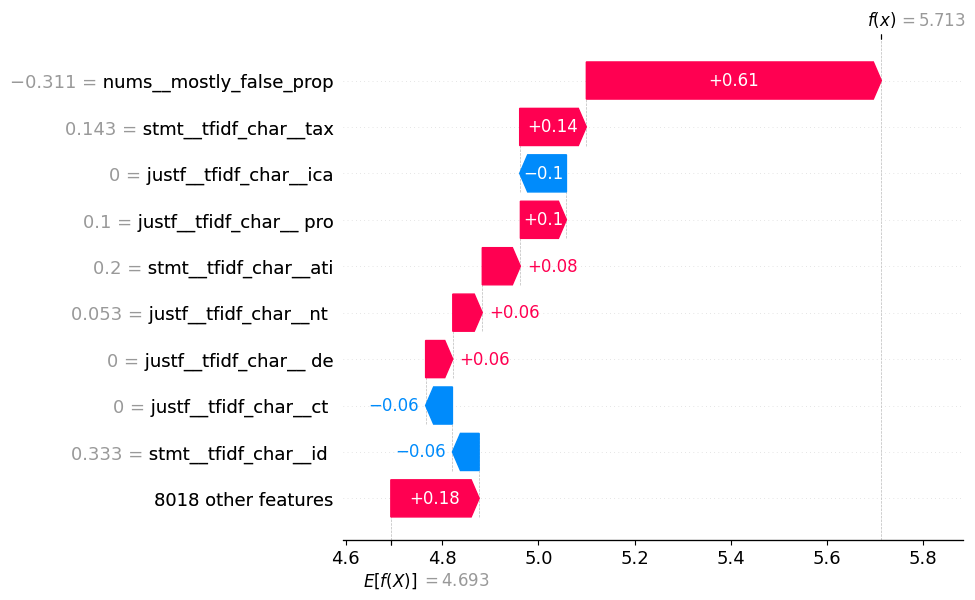

In [4]:
import shap
import pandas as pd
import scipy.sparse as sp

for name, model in models.items():
      if name not in ('NB', 'LogRegCal'):
        vectorizer = model.named_steps['pre']    
        clf        = model.named_steps['clf']
      
        X_train_vec = vectorizer.transform(X_train) 
        X_test_vec  = vectorizer.transform(X_test.iloc[[0]] ) 
      
      
        if sp.issparse(X_train_vec):
              X_train_arr = X_train_vec.toarray().astype(float)
        else:
              X_train_arr = X_train_vec.astype(float)
      
        if sp.issparse(X_test_vec):
              X_test_arr = X_test_vec.toarray().astype(float)
        else:
              X_test_arr = X_test_vec.astype(float)
      
        if name in ('SVM','LogReg'):
              explainer     = shap.LinearExplainer(
                  clf,
                  X_train_arr,
                  feature_perturbation="interventional"
              )
              # LinearExplainer devuelve shap_values como lista de arrays [n_classes x (n_samp,n_feat)]
              sv   = explainer.shap_values(X_test_arr)
              bv   = explainer.expected_value
        else:
              # árboles: RandomForest, HGB y XGBoost
              explainer = shap.TreeExplainer(clf, data=X_train_arr, feature_perturbation='interventional')
              # TreeExplainer devuelve LISTA en multiclass: shap_values[class][(n_samp,n_feat)]
              sv   = explainer.shap_values(X_test_arr, check_additivity=False)
              bv   = explainer.expected_value
             
        if hasattr(clf, "predict_proba"):
          probs = clf.predict_proba(X_test_arr)[0]
        else:
          probs = clf.decision_function(X_test_arr)[0]
      
        pred_idx = np.argmax(probs)

        exp_for_pred_class = sv[:, :, pred_idx][0]
      
        if isinstance(sv, list):
              # lista de length n_classes, cada array shape (1,n_features)
              vals = sv[pred_idx][0]
        else:
              # array shape (1, n_features, n_classes)
              vals = sv[0, :, pred_idx]

        base = bv[pred_idx]
        feature_names = vectorizer.get_feature_names_out()  # ← sacamos el vocabulario
        shap_values   = vals       

        df_shap = pd.DataFrame({
            'feature':    feature_names,
            'shap_value': vals
        }).sort_values('shap_value', ascending=False)

        print(f"→ Clase predicha = {pred_idx} (p≈{probs[pred_idx]:.2f})\n")
        print(f" Top 20 features que empujan hacia la clase {pred_idx}:")
        print(df_shap.head(20).to_string(index=False))
        print(f"\n Top 20 features que frenan la clase {pred_idx}:")
        print(df_shap.tail(20).to_string(index=False))

        exp = shap.Explanation(
              values      = vals,
              base_values = base,
              data        = X_test_arr[0],
              feature_names=feature_names
          )

        fondo = explainer.expected_value[pred_idx]
        shap_contribs = list(zip(feature_names, vals))
        # ordena por magnitud
        shap_contribs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        frases = []
        for feat, val in shap_contribs[:5]:  # tus top 5
            desc = humanize_feature(feat)
            signo = "aumenta" if val>0 else "disminuye"
            frases.append(f"La presencia de “{desc}” {signo} la probabilidad de clase {pred_idx} en {abs(val):.3f} puntos.")
        print(" ".join(frases))

        shap.plots.waterfall(exp, max_display=10)